In [1]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2

# Use Pandas to load dataset from csv file
import pandas as pd
import datetime

In [ ]:

%load_ext tensorboard

In [2]:
#import my dataset for colab
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [3]:
#load data and put into a file path
import pathlib

data_dir = pathlib.Path(r"/content/drive/MyDrive/Human Detection Tchibo/tchibologo_bingsearch")


In [4]:
#count the images
image_count = len(list(data_dir.glob('*/*')))
print(image_count)


2373


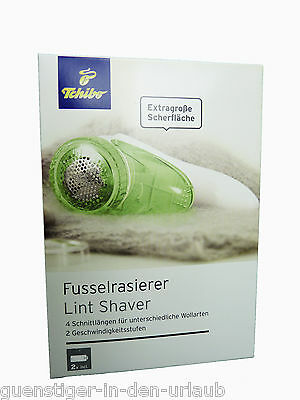

In [ ]:
#get an image of the mensche category
tchibologo = list(data_dir.glob('TchiboLogo/*'))
PIL.Image.open(str(tchibologo[0]))

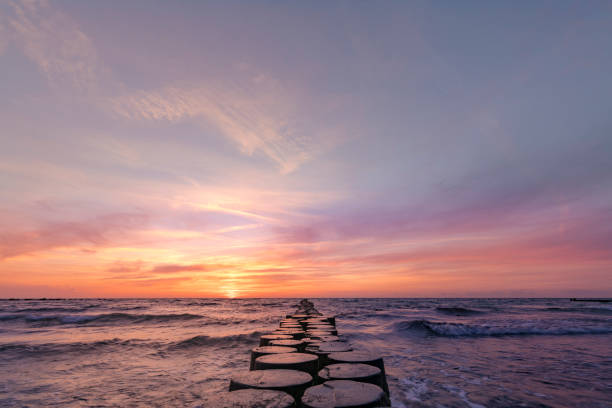

In [ ]:
#get an image of the KeinLogo category
keinlogo = list(data_dir.glob('KeinLogo/*'))
PIL.Image.open(str(keinlogo[0]))

In [5]:
#Hyperparameters for the data loader
batch_size = 8
img_height = 224
img_width = 224

In [6]:
#load data for training set
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)


Found 2373 files belonging to 2 classes.
Using 1899 files for training.


In [7]:
#load data for validation set
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)


Found 2373 files belonging to 2 classes.
Using 474 files for validation.


In [8]:
#print the class names of the dataset
class_names = train_ds.class_names
print(class_names)


['KeinLogo', 'TchiboLogo']


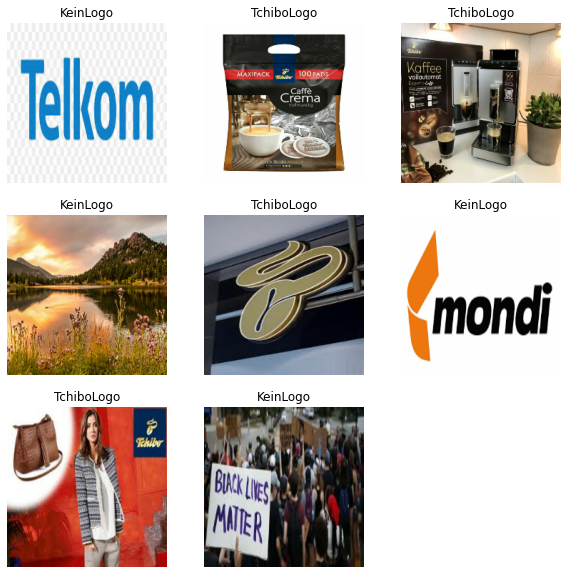

In [ ]:
#plot some examples of the train_set
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(8):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [9]:
#normalize the data 
# our dimension is 360*360 -1 for the input
# we want values between 0 and 1

normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255.0)


In [11]:
#check if pixel values are between 0 and 1 and apply normalization function on dataset
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))


0.0 1.0


In [12]:
#prepare data for better training perfomance
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
#add data augmentation
#add regularization l2/drop/BatchNormalization

In [13]:
#import and define pre trained model
#print model for an overview
model=keras.applications.MobileNetV2()
#model= keras.applications.ResNet152V2()
#print(model.summary())

14548992/14536120 [==============================] - 0s 0us/step


In [14]:
#adjust the model for our output

base_input=model.layers[0].input
base_output = model.layers[-2].output
final_output = layers.Dense(2, name="predictions")(base_output)
model_adjusted= keras.Model(inputs=base_input, outputs=final_output)

#print(adjusted_MNV2.summary())

In [ ]:
#compile the modell
model.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=False),
  metrics=['accuracy'])

In [ ]:
#creag logs for tensorboard for ech epoch
##path = "logs\\fit\\" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

#tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=path, histogram_freq=1)

In [15]:
def train_model(model):


  model.compile(optimizer='adam',
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

  logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
  tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

  model.fit(train_ds, 
            validation_data= val_ds,
            epochs=2, 
            callbacks=[tensorboard_callback])


train_model(model)

#model.fit(train_ds, 
            #validation_data= val_ds
            #epochs=3, 
            #validation_data=(x_test, y_test))

  #model.evaluate(
    #val_ds,
    #batch_size=8
#)


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


Epoch 1/2
238/238 [==============================] - 210s 823ms/step - loss: 0.5323 - accuracy: 0.8131 - val_loss: 1.3588 - val_accuracy: 0.8376
Epoch 2/2
238/238 [==============================] - 30s 126ms/step - loss: 0.2942 - accuracy: 0.8820 - val_loss: 1.1471 - val_accuracy: 0.6857


In [ ]:

#%tensorboard --logdir logs/fit

In [16]:
model.save("/content/drive/MyDrive/Human Detection Tchibo/TchiboLogoDetection_with_MobileNetV2_new")

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Human Detection Tchibo/TchiboLogoDetection_with_MobileNetV2_new/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


In [ ]:
#create a path list of the tchibo logo classified pictures (or other pictures) to parse them into model.predict
import os
filepaths=[]
d = "/content/drive/MyDrive/Human Detection Tchibo/tchibologo_bingsearch/TchiboLogo"
for path in os.listdir(d):
    full_path = os.path.join(d, path)
    filepaths.append(full_path)

print(len(filepaths))

893


In [ ]:
#Make predictions with the modell and evaluate wrong predictions
CATEGORIES = ["TchiboLogo", "KeinLogo"]  # will use this to convert prediction num to string value

#reshape the original images for expected input
def prepare(filepath):
    IMG_SIZE = 224  # 50 in txt-based
    img_array = cv2.imread(filepath)  # read in the image
    new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))  # resize image to match model's expected sizing
    return new_array.reshape(-1, IMG_SIZE, IMG_SIZE, 3)  # return the image with shaping that TF wants.

#Make predictions and if an image is not correctly classified add path to a list
#Here we can also add a label to the path to classify them later in the csv document (filepath/link + "TchiboLogo") --> get link, download image, predict and add label to link in one function
wrong_classified = []
for i in filepaths:
  prediction= model.predict([prepare(i)])
  #print(CATEGORIES[int(prediction[0][0])])
  if CATEGORIES[int(prediction[0][0])] != "TchiboLogo" :
    wrong_classified.append(i)

len(wrong_classified)

#here we can put the functionality into a class




8

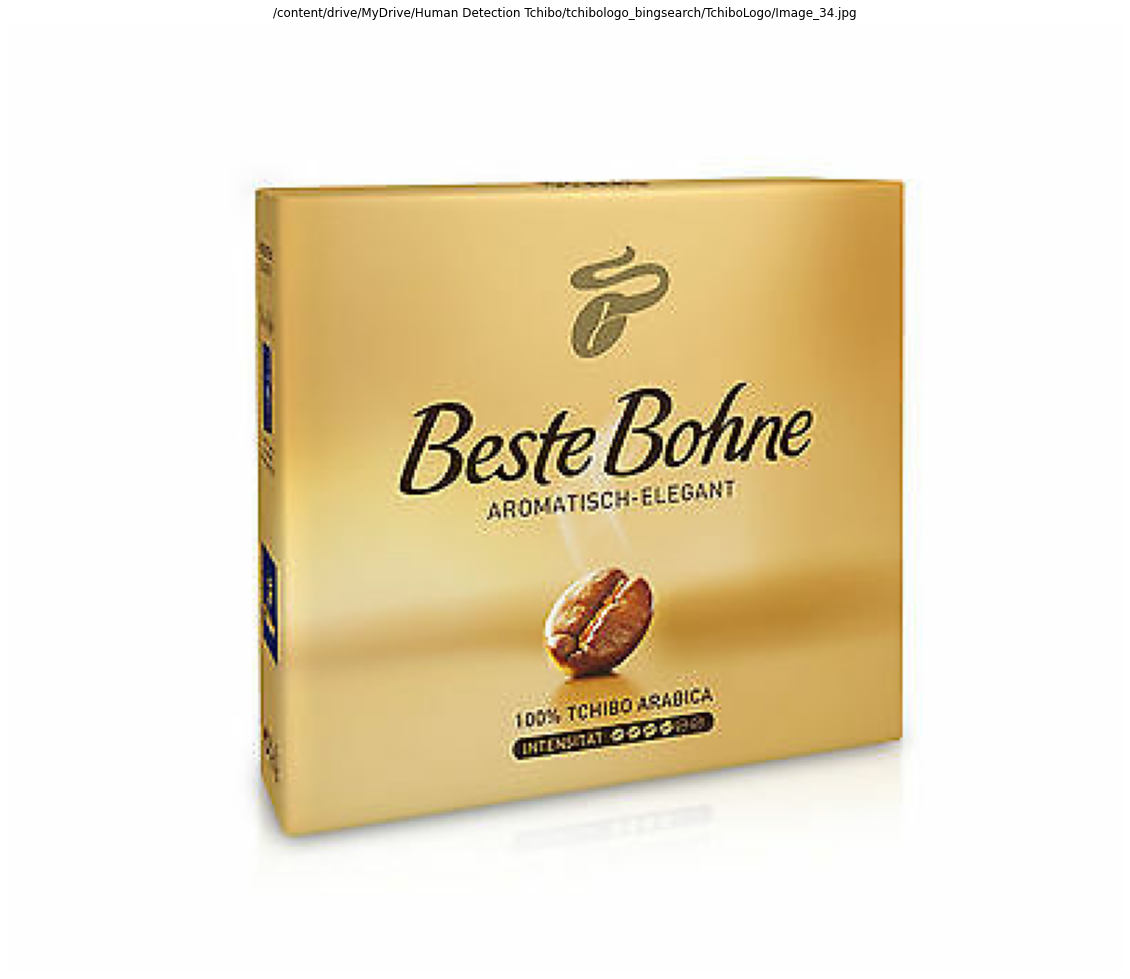

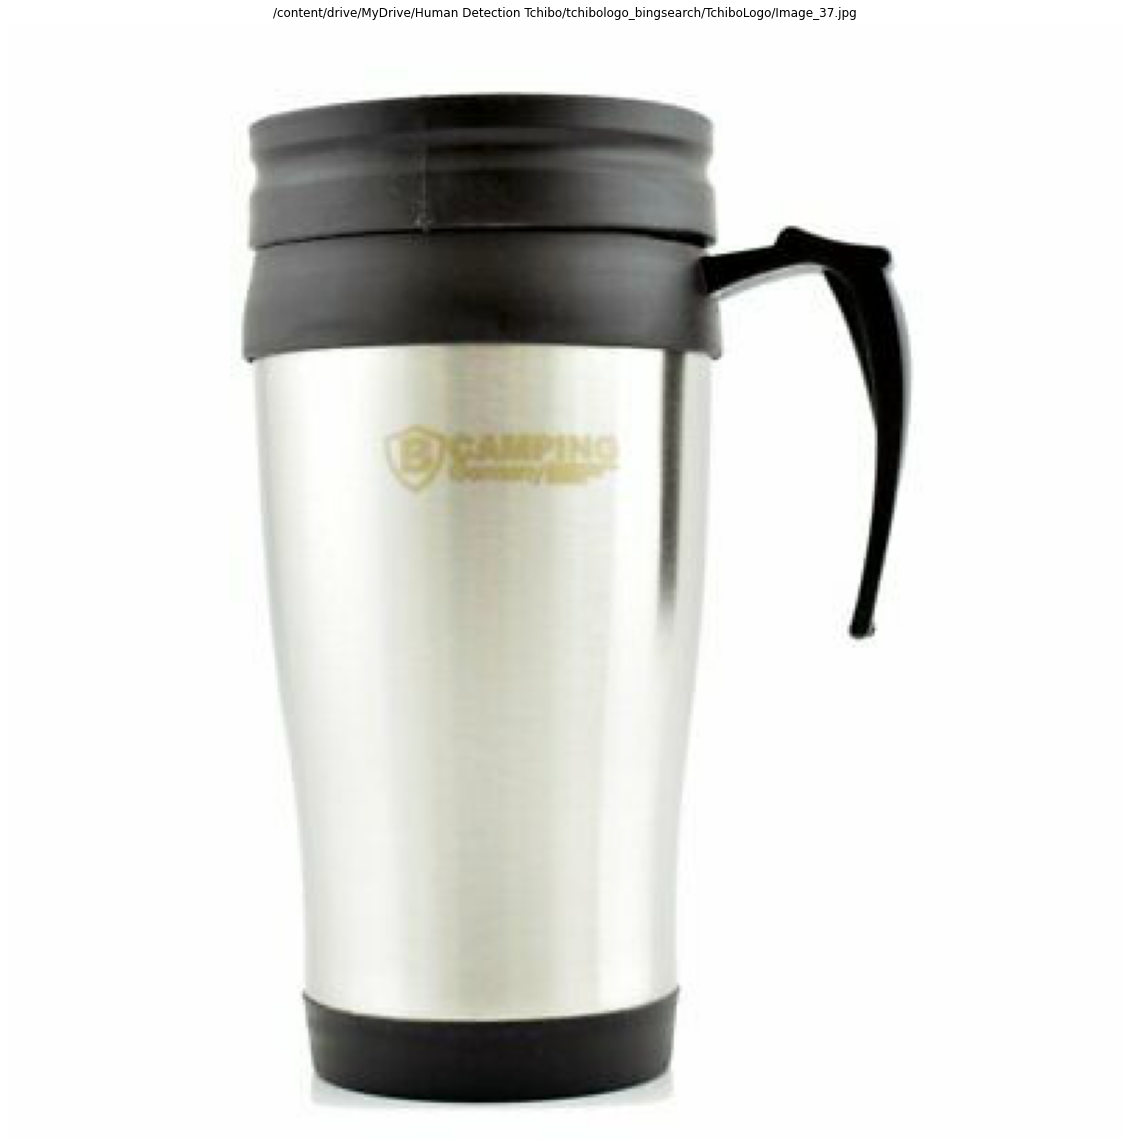

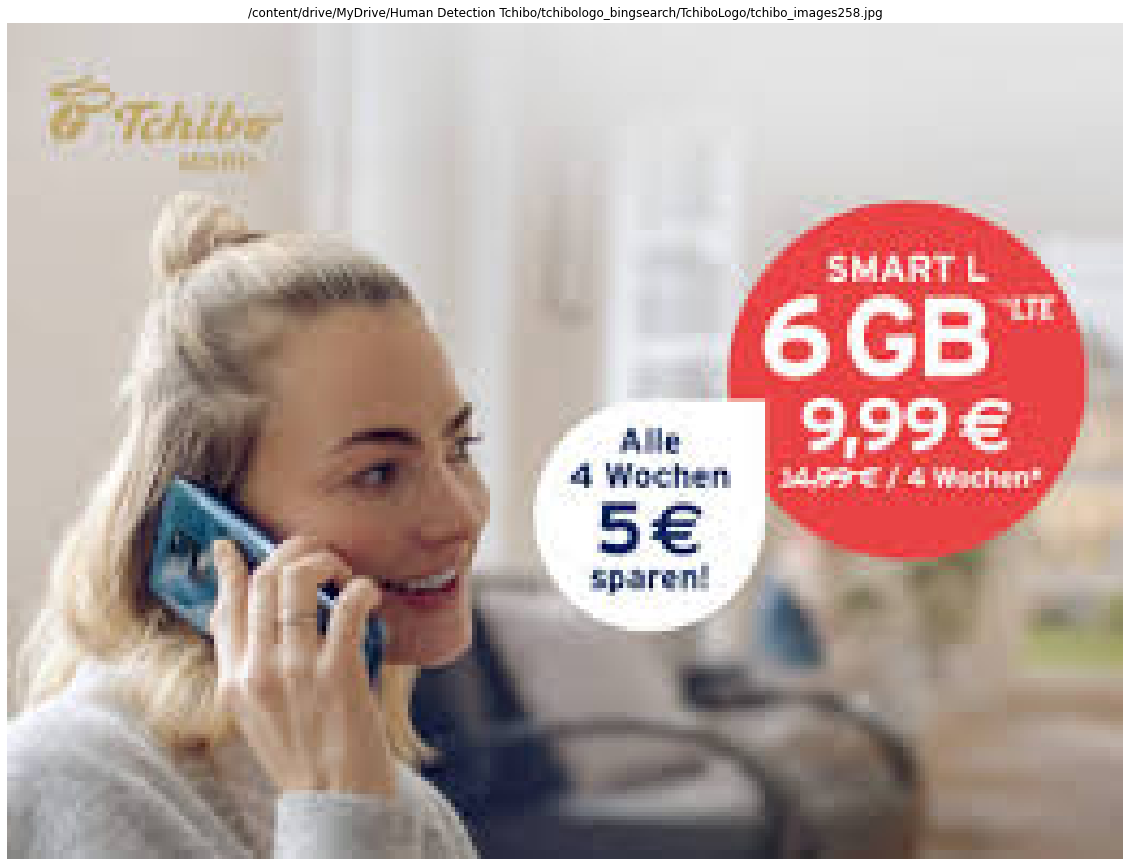

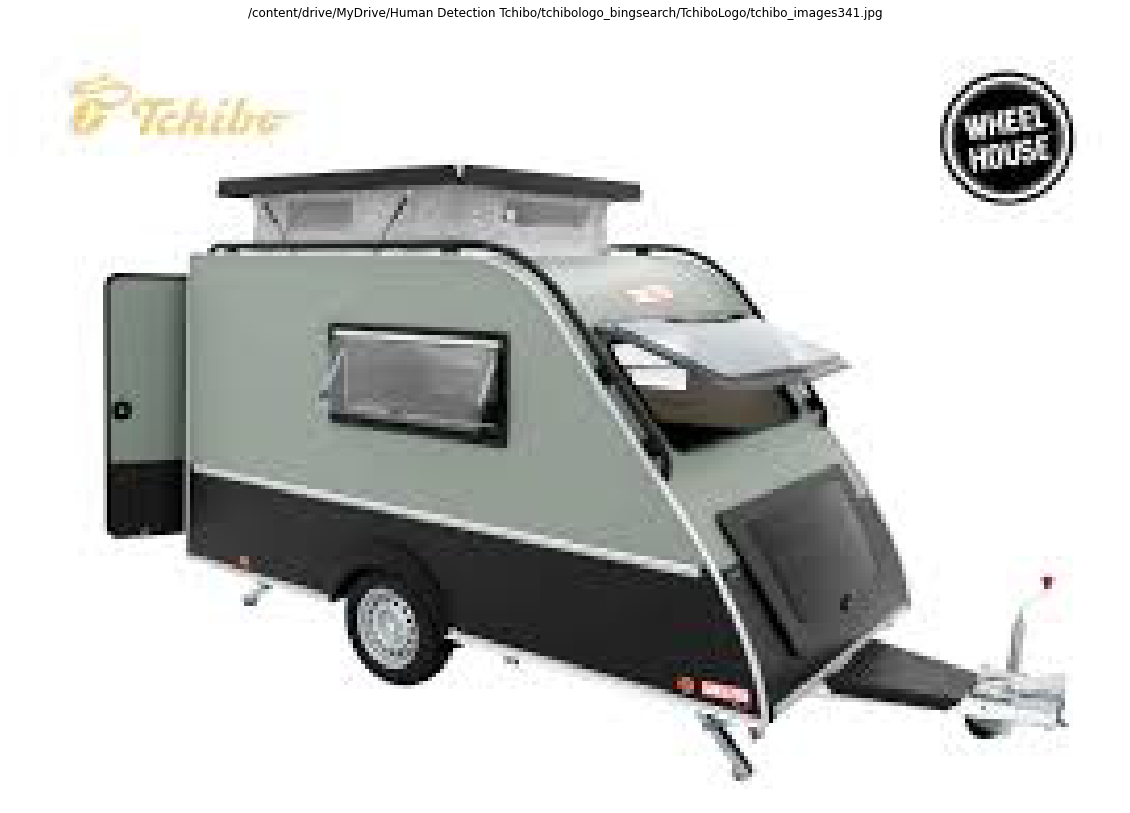

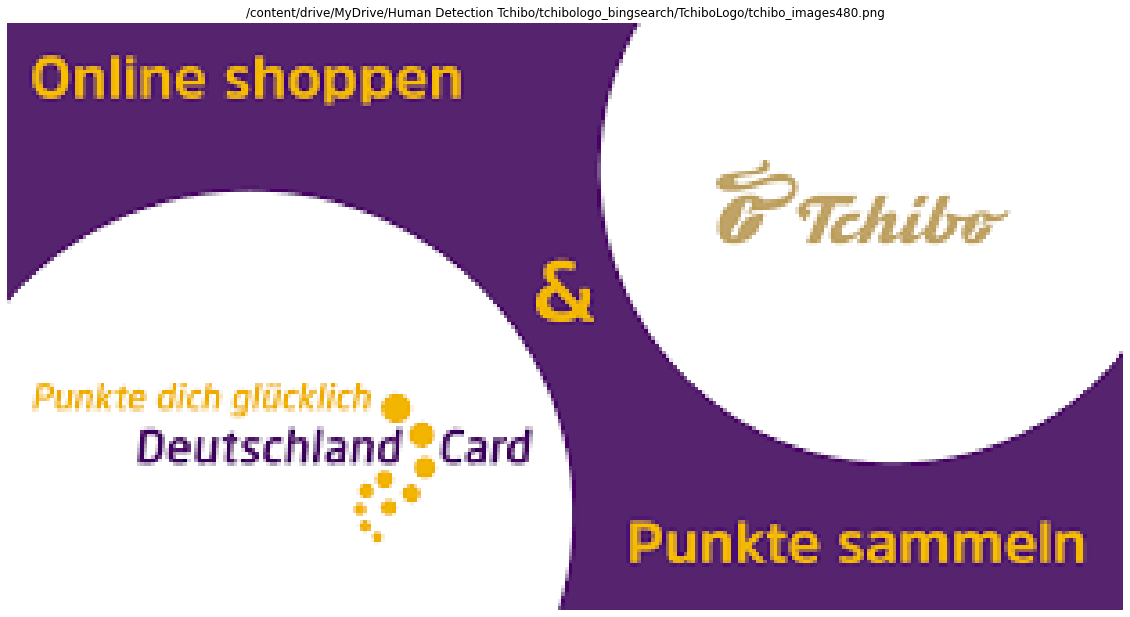

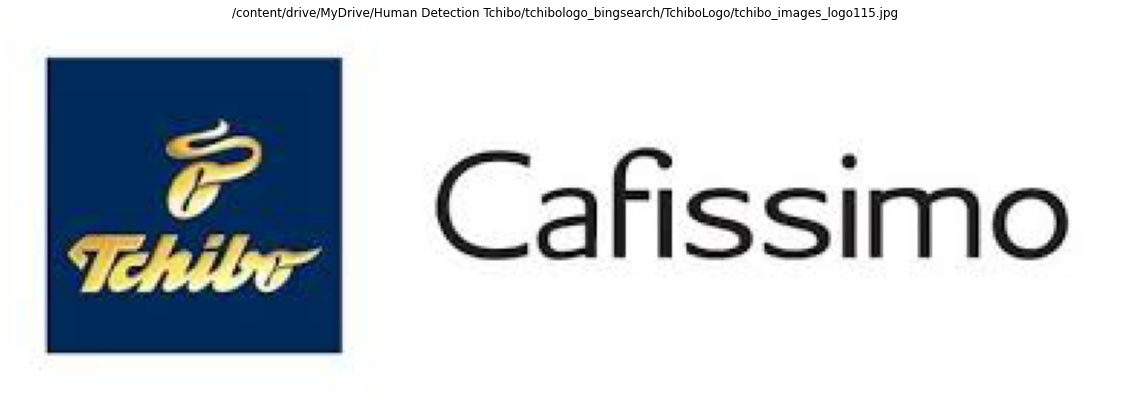

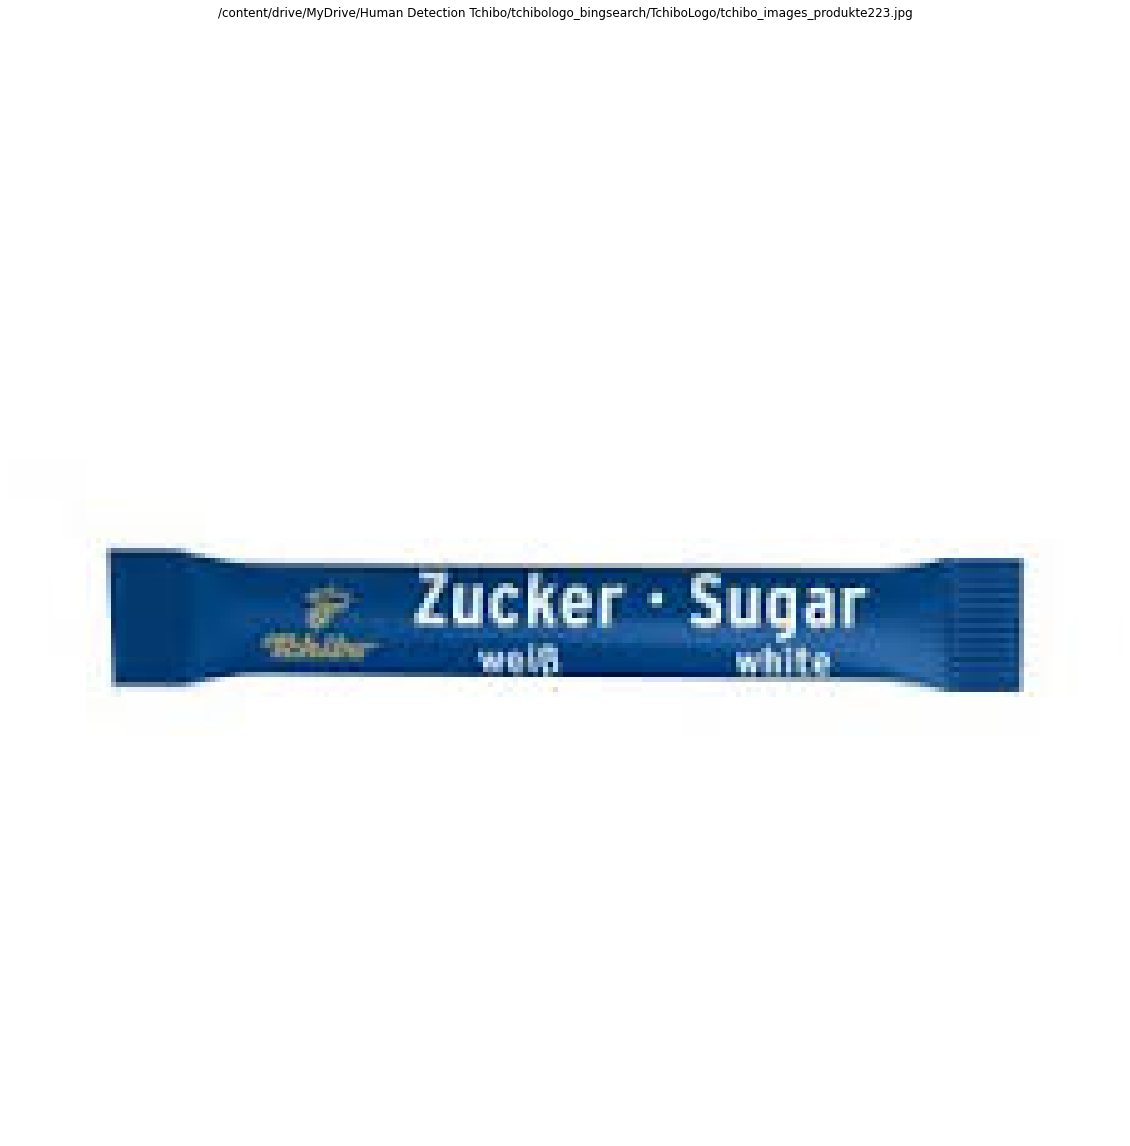

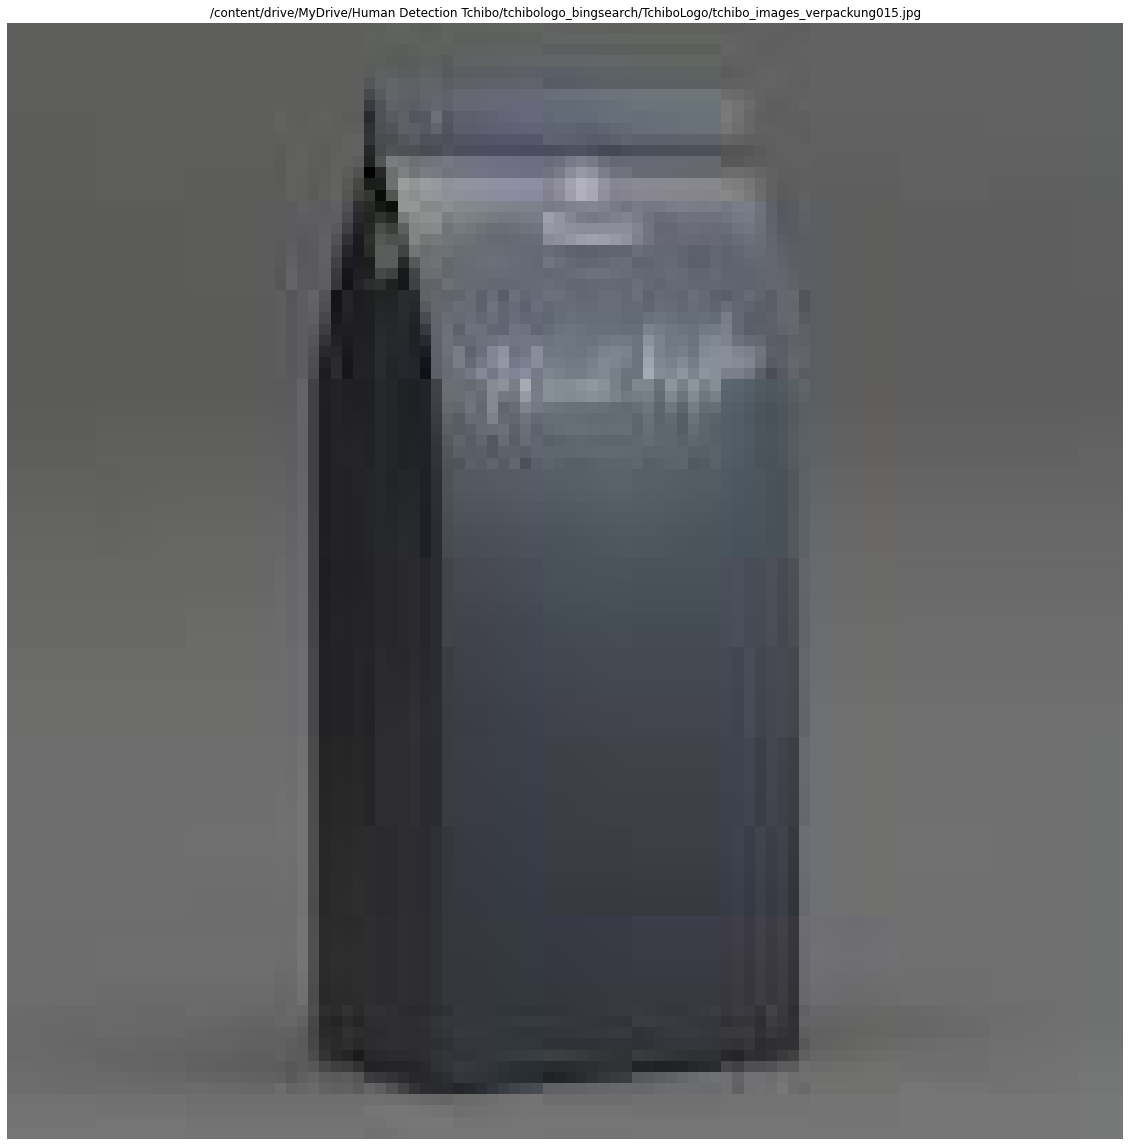

In [ ]:
#show the wrong classified images with path file
import matplotlib.pyplot as plt
counter=0
for i in wrong_classified:
    counter +=1
    pic_name = i
    image=plt.imread(pic_name)
    fig=plt.figure(figsize=(20,30))
    plt.imshow(image)
    plt.title(i)
    plt.axis('off')
    if counter > 10:
      break
    
    

  
  

Eigenes Modell auf Datensatz


In [ ]:
#data augmentation
data_augmentation = keras.Sequential(
    [
        tf.keras.layers.RandomCrop(224,224),
        tf.keras.layers.RandomContrast(factor=0.2),
        tf.keras.layers.RandomRotation(factor=0.3),
        tf.keras.layers.RandomZoom(height_factor=0.2),
    ]
) 

#custom model
model2 = tf.keras.Sequential([
  keras.Input((224,224,3)),
  data_augmentation,                           
  tf.keras.layers.Conv2D(256, 3, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Conv2D(128, 3, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Conv2D(64, 3, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Conv2D(32, 3, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Conv2D(16, 3, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(.2),
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dropout(.2),
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dropout(.2),
  tf.keras.layers.Dense(2, activation="softmax")
])
#model2.summary()

In [ ]:
train_model(model2)

Epoch 1/20
238/238 [==============================] - 48s 185ms/step - loss: 2.6363 - accuracy: 0.6184 - val_loss: 1.5441 - val_accuracy: 0.6181
Epoch 2/20
238/238 [==============================] - 42s 176ms/step - loss: 1.1648 - accuracy: 0.6179 - val_loss: 0.9764 - val_accuracy: 0.6350
Epoch 3/20
238/238 [==============================] - 42s 176ms/step - loss: 0.8724 - accuracy: 0.6132 - val_loss: 0.7804 - val_accuracy: 0.6857
Epoch 4/20
238/238 [==============================] - 43s 182ms/step - loss: 0.7538 - accuracy: 0.6511 - val_loss: 0.7253 - val_accuracy: 0.7194
Epoch 5/20
238/238 [==============================] - 42s 176ms/step - loss: 0.7349 - accuracy: 0.6532 - val_loss: 0.7262 - val_accuracy: 0.6540
Epoch 6/20
238/238 [==============================] - 42s 176ms/step - loss: 0.7340 - accuracy: 0.6589 - val_loss: 0.7043 - val_accuracy: 0.7004
Epoch 7/20
238/238 [==============================] - 42s 176ms/step - loss: 0.7217 - accuracy: 0.6658 - val_loss: 0.6873 - val_ac

KeyboardInterrupt: ignored